<a href="https://colab.research.google.com/github/s-miramontes/winter22project/blob/main/Simulation_for_IS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defnining variables

First lets define 'independent' variables that are drawn from a distribution  rather than from the model.  
In this particular case, these variables are the ones that, given our DAG, do not have arrows coming into them (i.e. those variables that are not influenced  by the model).  

### Load all the libraries in the following chunk

In [ ]:
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
#packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
#from rpy2.robjects.packages import importr
#from rpy2.robjects.vectors import StrVector
#utils = importr("utils")
#utils.chooseCRANmirror(ind=1)
#utils.install_packages(StrVector(packnames))

%load_ext rpy2.ipython
import numpy as np
import pandas as pd

import statsmodels.api as sm 
import statsmodels.formula.api as smf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.1.2-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Generating Identity Variables**

Less complex than education and cognition (these are categorical and binary).

In [ ]:
%%R
set.seed(62)
n=5000
age = round(rnorm(n, mean =50, sd = 13),1)
immigrant = rbinom(n, 1, .15)
race = sample(c(rep('white',times = n *.7),rep('black', times = n*.2),
                rep('other',times=n*.1)))
sex = sample(c(rep('female', times = n*.5),rep('male', times = n*.5)))

Of note we established that, most likely the immigrant variable would be influenced by the ethnicity variable. And we can figure out a way to draw samples given ethnicity. However, for the first part of the exmample and for simplicity we will just create a binomial variable for immigrant.  

## The Model
Given the following DAG we established our data generation rule using an example of how Maria would create these data on STATA:

**Generating Education:**

`generate mean_education = 12 - .1*age +2.5(age<50) * immigrant + (age>=50*immigrant) - black*immigrant - 1.5*other`

In [ ]:
%%R
x0 = 12
x1 = -.1*age
#I am not 100% sure about these but the syntax says: 
#If a person is younger than 50, multiply 2.5*immigrant status, else assign 0 (i.e. This coefficient doesn't count)
x2 = ifelse(age<50,2.5*immigrant,0) 
#If a person is 50 or older, just use immigrant status, else assign 0 (i.e. This coefficient doesn't count)                                    
x3 = ifelse(age>=50, immigrant, 0)  
#If a person's race is black assign a -1 else assign 0 (i.e. This coefficient doesn't count)     
x4 = ifelse(race=="black",-1,0)
#If a person's race is other assign a -1.5 else assign 0 (i.e. This coefficient doesn't count)    
x5 = ifelse(race=="other",-1.5,0)

mean_education = round((x0 + x1 + x2 +x3 + x4 + x5),1)

Alternatively we can code it as:

In [ ]:
%%R 
mean_educ2 = round((12 - (.1*age) + (age<50)*2.5*immigrant - (age>=50)*immigrant - 1*(race=='black') - 1.5*(race=="other")),1)

Now we assign a random term to education and combine it with the mean education

In [ ]:
%%R
random_education = rnorm(n)*2
education = round((mean_education + random_education),1)

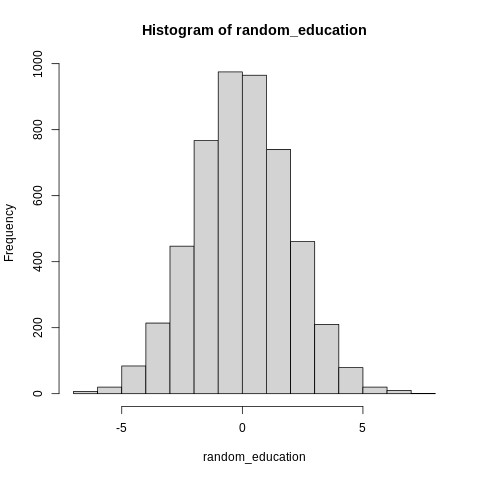

In [ ]:
%%R
hist(random_education)

**Generating Cognition:**

We'll do the same for cognition:

- Pull from a random ~normal distribution (an approximation)
- Based on education, race, age, and immigrant status
- The sum of the two


In [ ]:
%%R
r_cognition = rnorm(n, mean=0, sd=1)
mean_cognition = education*.1 - 0*(race=='black') - 0*(race=='other') - 0.05*age - 0.05*immigrant
cognition = r_cognition + mean_cognition

Now we need to create the strata by different combinations of variables that we created (2^3). 
* If female and immigrant and less than 50 <- stratum 1
* If female and immigrant and more than 50 <- stratum 2
* If female and non-immigrant and less than 50 <- stratum 3
* If female and non-immigrant and more than 50 <- stratum 4
* If male and immigrant and less than 50 <- stratum 5
* If male and immigrant and more than 50 <- stratum 6
* If male and non-immigrant and less than 50 <- stratum 7
* If male and non-immigrant and more than 50 <- stratum 8


Since we established a rule for age where there is a cutoff we need to create a variable that reflects this cutoff (i.e. making age binary)

In [ ]:
%%R
bin_age = as.numeric(age <50)

To make easy reading the code we can put all these on a dataframe

In [ ]:
%%R
npat = seq(1:n)
data = data.frame(npat, age, sex,
                  immigrant,
                  race,
                  mean_education,
                  education,
                  bin_age,
                  cognition,
                  x0,x1,x2,x3,x4,x5)
head(data, 20)

Let's create the groups for IS using python syntax. 
First we need to create a dataframe with all the variables



In [ ]:
data = %R data[,1:9]
df = pd.DataFrame(data)
df.head()

,npat,age,sex,immigrant,race,mean_education,education,bin_age,cognition
1,1,60.4,male,0,black,5.0,3.0,0.0,-3.880608
2,2,53.7,male,0,white,6.6,6.1,0.0,-3.900686
3,3,30.3,male,0,white,9.0,8.5,1.0,-1.079787
4,4,51.0,male,0,white,6.9,4.3,0.0,-1.383333
5,5,79.4,male,1,white,5.1,5.3,0.0,-3.173400


**Categories**:

These are the rules for the different groups.
* Group/Cluster 1: Female, non-immigrants, age > 50
* Group/Cluster 2: Female, non-immigrants, age < 50
* Group/Cluster 3: Female, immigrants, age > 50
* Group/Cluster 4: Female, immigrants, age < 50
* Group/Cluster 5: Male, non-immigrants, age > 50
* Group/Cluster 6: Male, non-immigrants, age < 50
* Group/Cluster 7: Male, immigrants, age > 50
* Group/Cluster 8: Male, immigrants, age < 50

Select 1 from:
- Immigrant Status
- Sex
- Race/Ethnicity
- Age (greater than 50 or not)
- Education?

In [ ]:
conditions = [
    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] >= 50) & (df['race'] == 'white'),
    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] >= 50) & (df['race'] == 'black'),
    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] >= 50) & (df['race'] == 'other'),
    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] >= 50) & (df['race'] == 'white'),
    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] >= 50) & (df['race'] == 'black'),
    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] >= 50) & (df['race'] == 'other'),
    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] >= 50) & (df['race'] == 'white'),
    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] >= 50) & (df['race'] == 'black'),
    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] >= 50) & (df['race'] == 'other'),
    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] >= 50) & (df['race'] == 'white'),
    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] >= 50) & (df['race'] == 'black'),
    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] >= 50) & (df['race'] == 'other'),
    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] < 50) & (df['race'] == 'white'),
    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] < 50) & (df['race'] == 'black'),
    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] < 50) & (df['race'] == 'other'),
    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] < 50) & (df['race'] == 'white'),
    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] < 50) & (df['race'] == 'black'),
    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] < 50) & (df['race'] == 'other'),
    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] < 50) & (df['race'] == 'white'),
    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] < 50) & (df['race'] == 'black'),
    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] < 50) & (df['race'] == 'other'),
    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] < 50) & (df['race'] == 'white'),
    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] < 50) & (df['race'] == 'black'),
    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] < 50) & (df['race'] == 'other')
]

# now 24 groups
groups = np.arange(1,25)

df['group'] = np.select(conditions, groups, default = 0)

In [ ]:
pd.DataFrame(df['group'].value_counts()).T

,19,1,7,13,2,20,14,8,22,4,3,16,10,15,9,21,17,5,23,11,18,12,24,6
group,776,772,755,693,229,210,208,207,142,130,129,116,116,100,93,89,45,34,34,33,28,24,21,16


In [ ]:
df['race'] = df['race'].astype('category')
df['group'] = df['group'].astype('category')

In [ ]:
df.head()

,npat,age,sex,immigrant,race,mean_education,education,bin_age,cognition,group
1,1,60.4,male,0,black,5.0,3.0,0.0,-3.880608,8
2,2,53.7,male,0,white,6.6,6.1,0.0,-3.900686,7
3,3,30.3,male,0,white,9.0,8.5,1.0,-1.079787,19
4,4,51.0,male,0,white,6.9,4.3,0.0,-1.383333,7
5,5,79.4,male,1,white,5.1,5.3,0.0,-3.173400,10


Simulated Data is now generated, or so I believe.


**Simple Linear Model in R**
Note that the group column must be redefined, since we named it categorical for Python purposes.

In [ ]:
%%R -i df
data = data.frame(df)
model_1 = lm(cognition~age + immigrant + as.factor(race) + (bin_age*immigrant) + as.factor(group), data=data)
summary(model_1)

/usr/local/lib/python3.7/dist-packages/rpy2/robjects/pandas2ri.py:62: UserWarning: Error while trying to convert the column "group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  % (name, str(e)))


AttributeError: ignored

--------------------------------------------------

# Multilevel Model with Python

In [ ]:
#model_py = smf.mixedlm("cognition ~ age + immigrant + race + (bin_age*immigrant)",
                       #df, groups=df['group'])
model_py = smf.mixedlm("cognition ~ age + immigrant + race ",
                       df, groups=df['group'])
mdf_py = model_py.fit()
mdf_py.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: cognition 
No. Observations:  5000    Method:             REML      
No. Groups:        24      Scale:              1.0473    
Min. group size:   16      Likelihood:         -7223.8508
Max. group size:   776     Converged:          Yes       
Mean group size:   208.3                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      1.203    0.052  23.194 0.000  1.102  1.305
race[T.other] -0.095    0.056  -1.682 0.093 -0.205  0.016
race[T.white]  0.048    0.036   1.324 0.186 -0.023  0.119
age           -0.062    0.001 -81.036 0.000 -0.063 -0.060
immigrant      0.126    0.040   3.165 0.002  0.048  0.204
Group Var      0.000                                     
=========================================================

"""

****
## How do we extract the other components of the fit model?
- `random_effects`: returns the conditional means of random effects given the data.
- `random_effects_cov`: returns the conditional covariance matrix of the random effects for each group given the data.
- `resid`: returns the residuals for the model.
- `bse`: returns the standard errors of the parameter estimates.
- `bse_fe`: returns the standard errors of the fixed effect regression coefficients
- `bse_re`: returns the standard errors of the variance parameters.
- `fittedvalues`: returns the fitted values for the model
- `pvalues`: the two tailed p values for the t-stats of the params 

*Note that there are more properties, and attributes that could be extracted from the model generated object. For more info, visit here: https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.html#statsmodels.regression.mixed_linear_model.MixedLMResults*

In [ ]:
# conditional means of random effects given the data
mdf_py.random_effects

{1: Group    0.000657
 dtype: float64, 2: Group    0.000225
 dtype: float64, 3: Group    0.000184
 dtype: float64, 4: Group    0.000608
 dtype: float64, 5: Group   -0.000396
 dtype: float64, 6: Group   -0.000194
 dtype: float64, 7: Group   -0.000143
 dtype: float64, 8: Group   -0.00015
 dtype: float64, 9: Group    0.000176
 dtype: float64, 10: Group   -0.000815
 dtype: float64, 11: Group   -0.000079
 dtype: float64, 12: Group    0.000449
 dtype: float64, 13: Group   -0.000403
 dtype: float64, 14: Group    0.000273
 dtype: float64, 15: Group    0.000536
 dtype: float64, 16: Group    0.000193
 dtype: float64, 17: Group   -0.000053
 dtype: float64, 18: Group   -0.000016
 dtype: float64, 19: Group   -0.000585
 dtype: float64, 20: Group   -0.000113
 dtype: float64, 21: Group   -0.000658
 dtype: float64, 22: Group    0.000488
 dtype: float64, 23: Group    0.000293
 dtype: float64, 24: Group   -0.000477
 dtype: float64}

In [ ]:
# fitted values
mdf_py.fittedvalues

1      -2.515886
2      -2.055424
3      -0.615067
4      -1.889178
5      -3.512507
          ...   
4996   -0.879525
4997   -1.447378
4998   -2.164547
4999   -3.256090
5000   -2.279631
Length: 5000, dtype: float64

***************


## Another linear model in R

In [ ]:
%%R -i df
data = data.frame(df)
model_1 = lm(cognition ~ age + immigrant + as.factor(race) + (bin_age*immigrant) + as.factor(group), data=data)


/usr/local/lib/python3.7/dist-packages/rpy2/robjects/pandas2ri.py:62: UserWarning: Error while trying to convert the column "group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  % (name, str(e)))


AttributeError: ignored

------------------------------------------------------------------------


## Iterating over multiple samples
Trying for populations of size n:

- 500
- 5,000
- 10,*000*


In [ ]:
# save all df's
dfs_all = []

groups = np.arange(1,25)

In [ ]:


%%R
dfs = list()

# age stats
mean_age = 50
sd_age = 13

# race dists
per_white = 0.70
per_black = 0.20
per_other = 0.10

# sex dists
per_fem = 0.50
per_male = 0.50

# immigrant binom
size = 1
prob = 0.15

# coeff model
educ_int = 12
age_coef = 0.10
imm_coef = 2.5
wt_black = 1
wt_other = 1.5

# cognition coefs
educ_coef = 0.10
raceB_coef = 0
raceO_coef = 0
age_coef = 0.05
immi_coef = 0.05
rc_mean = 0
rc_sd = 1


pop_sizes = c(5000, 10000,50000, 100000)


for (i in 1:length(pop_sizes)){
    
    # identities
    age = round(rnorm(pop_sizes[i], mean = mean_age, sd = sd_age),1)
    race = sample(c(rep('white', times = pop_sizes[i] * per_white), rep('black', times = pop_sizes[i] * per_black), rep('other', times= pop_sizes[i] * per_other)))
    sex = sample(c(rep('female', times = pop_sizes[i] * per_fem), rep('male', times = pop_sizes[i] * per_male)))
    immigrant = rbinom(pop_sizes[i], size, prob)

    # education (mean)
    age_comp = age_coef * age
    imm_age_int = (age<50)*imm_coef - (age>=50)*immigrant
    race_comp = -wt_black*(race=='black') - wt_other*(race=='other')
    mean_educ = round((educ_int - age_comp + imm_age_int + race_comp), 1)
    # random
    random_educ = rnorm(pop_sizes[i])*2
    education = round((mean_educ + random_educ), 1)

    #cognition (mean)
    mean_cog = education*educ_coef - raceB_coef*(race=='black')- raceO_coef*(race=='other') - age_coef*age - immi_coef*immigrant
    random_cog = rnorm(pop_sizes[i], mean = rc_mean, sd =  rc_sd)
    cognition = (mean_cog + random_cog)

    # categorize age whether less than 50 or not
    bin_age = as.numeric(age<50)

    #building dataframe
    num_patients = seq(1:pop_sizes[i])
    data = data.frame(num_patients, age, sex,
                      immigrant, race,
                      mean_educ, education,
                      bin_age, cognition)
    data2 = list(num_patients, age, sex, immigrant, race, mean_educ, education, bin_age, cognition)
    dfs[i] <- data
    # pythonize
    #data = %R data[,1:9]
    #df = pd.DataFrame(data)
    #df['group'] = np.select(conditions, groups, default = 0)
    #df['race'] = df['race'].astype('category')
    #df['group'] = df['group'].astype('category')

    #dfs_all.append(df)  
}

In [ ]:
dfs_py = []
for i in range(1,5):
  
  data = %R dfs[i]
  #print(type(data))
  #break
  dfs_py.append(data)


In [ ]:
pd.DataFrame(dfs_py[0])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99960,99961,99962,99963,99964,99965,99966,99967,99968,99969,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99985,99986,99987,99988,99989,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,99961,99962,99963,99964,99965,99966,99967,99968,99969,99970,99971,99972,99973,99974,99975,99976,99977,99978,99979,99980,99981,99982,99983,99984,99985,99986,99987,99988,99989,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999,100000


--------------------------------------------------------------

**Boneyard**

**A Sample Model from toy dataset**



In [ ]:
data_sample = sm.datasets.get_rdataset("dietox", "geepack").data
data_sample.head()

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5


In [ ]:
md = smf.mixedlm("Weight ~ Time", data_sample, groups=data_sample['Pig'])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Likelihood:         -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            



In [ ]:
#conditions = [
#    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] >= 50),
#    (df['sex'] == 'female') & (df['immigrant'] == 0) & (df['age'] < 50),
#    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] >= 50),
#    (df['sex'] == 'female') & (df['immigrant'] == 1) & (df['age'] < 50),
#    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] >= 50),
#    (df['sex'] == 'male') & (df['immigrant'] == 0) & (df['age'] < 50),
#    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] >= 50),
#    (df['sex'] == 'male') & (df['immigrant'] == 1) & (df['age'] < 50)
#]
#groups = [1,2,3,4,5,6,7,8]

#df['group'] = np.select(conditions, groups, default = 0)

In [ ]:
v_imm = np.unique(df['immigrant'])
v_sex = np.unique(df['sex'])
v_race = np.unique(df['race'])
v_age = np.unique(df['bin_age'])


In [ ]:
strata = np.array(np.meshgrid(v_age, v_sex, v_imm, v_race)).T.reshape(-1,4)

dict_strata = {}
for i,group in enumerate(strata,1):
  dict_strata[i] = group

In [ ]:
dict_strata